![Imagen de WhatsApp 2024-12-10 a las 14.15.17_7a97cd4a.jpg](<attachment:Imagen de WhatsApp 2024-12-10 a las 14.15.17_7a97cd4a.jpg>)
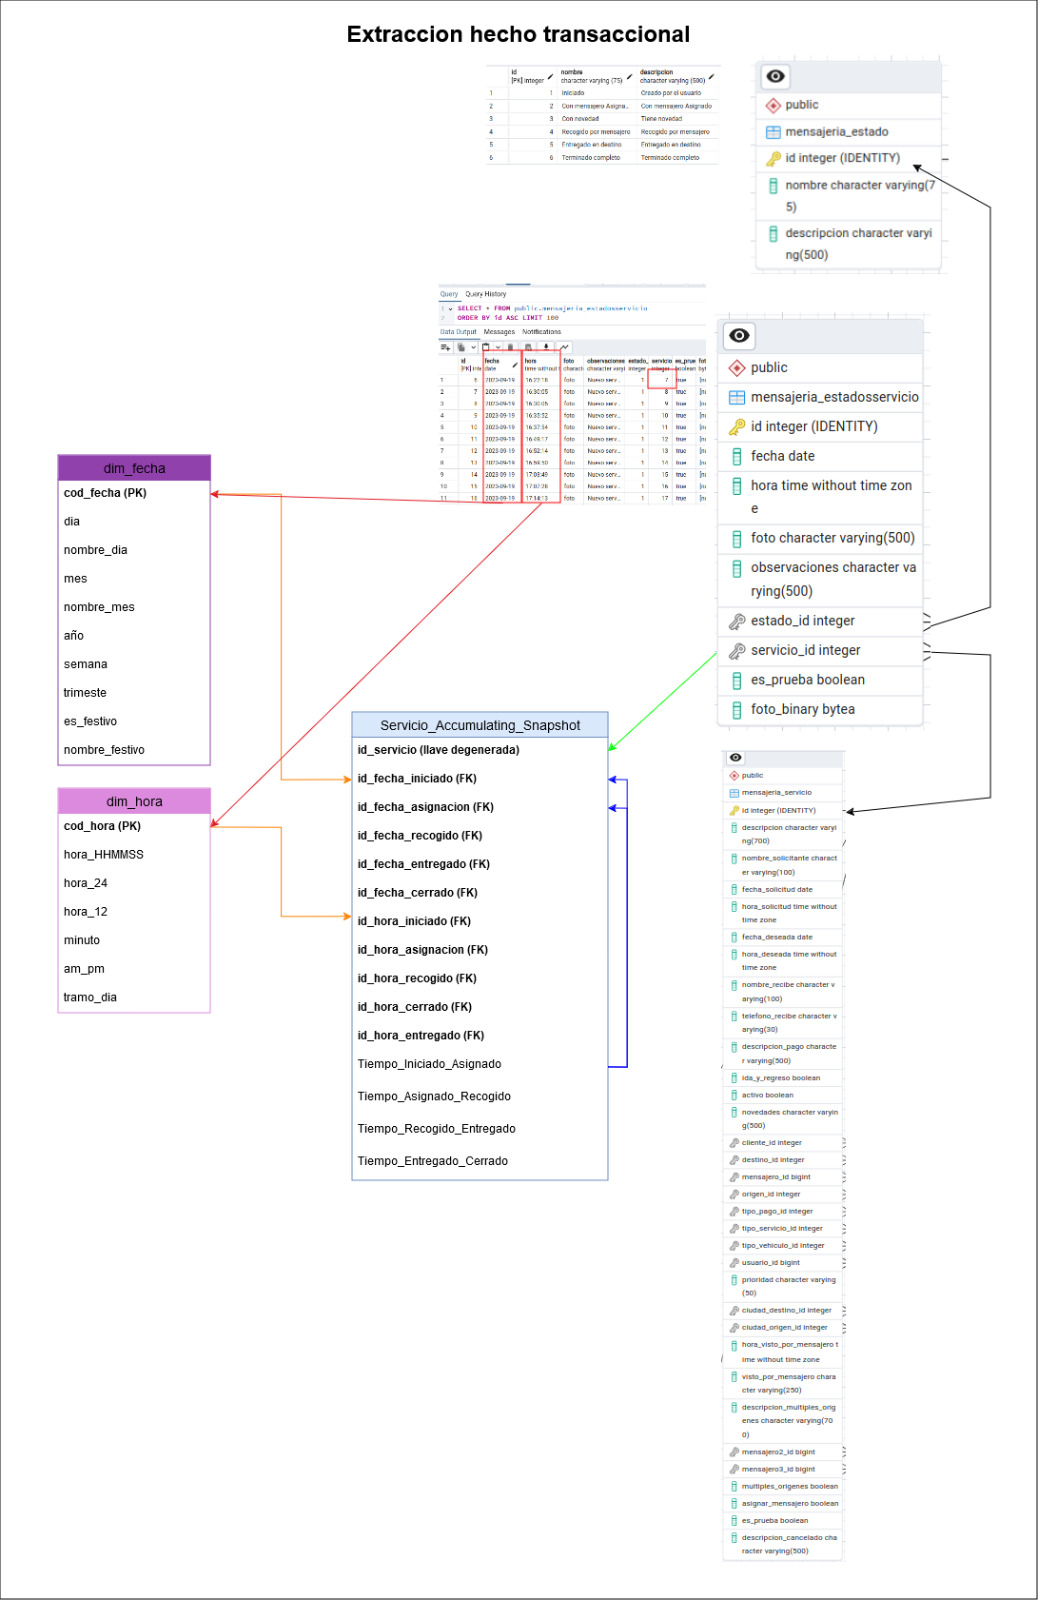

## Importar librerías

In [ ]:
import pandas as pd
import sqlalchemy as sa
import utils.conn_tools as ct
from datetime import datetime, timedelta, time
import numpy as np

## Conexión con base de datos

In [ ]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

### Asimilación de dimensiones

In [ ]:
# Create table
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

## Extract

In [ ]:
# Leer los datos de las tablas

# De la fuente
definicion_estados_df = pd.read_sql_table("mensajeria_estado", con=engine_src)
estados_servicio = pd.read_sql_table("mensajeria_estadosservicio", con=engine_src)
msj_servicio = pd.read_sql_table("mensajeria_servicio", con=engine_src)

# Del Warehouse
dim_fecha = pd.read_sql_table("dim_fecha", con=engine_etl)
dim_hora = pd.read_sql_table("dim_hora", con=engine_etl)
dim_mensajero = pd.read_sql_table("dim_mensajero", con=engine_etl)

In [ ]:
# Comprobar los campos
definicion_estados_df.head(6)

In [ ]:
# Comprobar los campos
estados_servicio.head(3)

## Transform: Ajustes de la dimensión

### Filtrar solo los datos necesarios de la fuente

In [ ]:
# Copia los datos necesarios en el DataFrame
servicio_df = estados_servicio[
    [
        "servicio_id",
        "estado_id" ,
        "fecha",
        "hora",
    ]
].copy()

servicio_df["fecha"] = pd.to_datetime(servicio_df["fecha"]).dt.date
servicio_df["hora"] = servicio_df["hora"].apply(
    lambda x: x.replace(second=0).strftime("%H:%M:%S") if pd.notnull(x) else None
)

servicio_df.head(3)

### Realizar JOIN con estados, horas y fechas

In [ ]:
definicion_estados_df.head(6)

In [ ]:
# Combinar las tablas para obtener los textos de los estados
merged_df = servicio_df.merge(
    definicion_estados_df,
    how="left",
    left_on="estado_id",
    right_on="id",
    suffixes=("", "_estado"),
)

merged_df = merged_df[["servicio_id", "fecha", "hora", "nombre"]]
merged_df.rename(columns={"nombre": "nombre_estado"}, inplace=True)

merged_df.head(3)

In [ ]:
# Suponiendo que merged_df tiene una columna 'hora' en formato "HH:MM:SS"
# Asegúrate de convertir la columna de hora a tipo de dato adecuado
merged_df["hora"] = pd.to_datetime(
    merged_df["hora"], format="%H:%M:%S", errors="coerce"
).dt.time

# Convirtiendo a tipo fechas para poder hacer merge con dim_fecha
merged_df["fecha"] = pd.to_datetime(
    merged_df["fecha"], format="%Y-%m-%d", errors="coerce"
)
dim_fecha["date"] = pd.to_datetime(
    dim_fecha["date"], format="%Y-%m-%d", errors="coerce"
)

# Combina con dim_fecha
merged_df = merged_df.merge(
    dim_fecha, how="left", left_on="fecha", right_on="date", suffixes=("", "_fecha")
)

# Asegurando que la columna de hora en dim_hora se trate como tiempo
dim_hora_table = sa.Table("dim_hora", metadata, autoload_with=engine_etl)

# Convertimos la columna de hora a datetime para hacer el merge
dim_hora["hour_HHMMSS"] = pd.to_datetime(
    dim_hora["hour_HHMMSS"], format="%H:%M:%S", errors="coerce"
).dt.time

# Combina con dim_hora
merged_df = merged_df.merge(
    dim_hora, how="left", left_on="hora", right_on="hour_HHMMSS", suffixes=("", "_hora")
)

# Nos quedamos solo con los campos de fecha y hora relevantes
merged_df = merged_df[
    ["servicio_id", "key_fecha", "date", "hora", "key_hora", "nombre_estado"]
]

merged_df.rename(columns={"date": "dim_fecha_date"}, inplace=True)
merged_df.head(6)

In [ ]:
# Combina con dim_hora
merged_df = merged_df.merge(
    dim_hora,
    how="left",
    left_on="hora",
    right_on="hour_HHMMSS",
    suffixes=("", "_hora"),
)

# Nos quedamos solo con los campos de fecha relevantes
merged_df = merged_df[
    [
        "servicio_id",
        "key_fecha",
        "dim_fecha_date",
        "key_hora",
        "hour_HHMMSS",
        "nombre_estado",
    ]
]

merged_df.rename(columns={"hour_HHMMSS": "dim_hora_hour_HHMMSS"}, inplace=True)

merged_df.head(10)

### Agrupar servicios por id, obtener las fechas y horas de sus estados y los tiempos de diferencia

In [ ]:
# Ejemplo de un servicio ya completado
# Filtrar los registros donde servicio_id es igual a 842
merged_df[merged_df["servicio_id"] == 842] # ["dim_fecha_date"].values[0]

In [ ]:
class Estado:
    def __init__(self, nombre, fecha, hora):
        self.nombre = nombre
        self.fecha = fecha
        self.hora = hora


estados = [
    Estado("Iniciado", "fecha_iniciado", "hora_iniciado"),
    Estado("Con mensajero Asignado", "fecha_asignado", "hora_asignado"),
    Estado("Recogido por mensajero", "fecha_recogido", "hora_recogido"),
    Estado("Entregado en destino", "fecha_entregado", "hora_entregado"),
    Estado("Terminado completo", "fecha_cerrado", "hora_cerrado"),
]


def calcular_diferencia_en_minutos(fecha_inicio, hora_inicio, fecha_fin, hora_fin):
    try:
        # Convertir las fechas a tipo datetime
        fecha_inicio_dt = pd.to_datetime(fecha_inicio)
        fecha_fin_dt = pd.to_datetime(fecha_fin)

        # Convertir las horas a cadenas si son de tipo time
        if isinstance(hora_inicio, pd.Timestamp):
            hora_inicio = hora_inicio.time()
        if isinstance(hora_fin, pd.Timestamp):
            hora_fin = hora_fin.time()

        # Convertir las horas a tipo timedelta
        hora_inicio_str = (
            hora_inicio.strftime("%H:%M:%S")
            if isinstance(hora_inicio, time)
            else hora_inicio
        )
        hora_fin_str = (
            hora_fin.strftime("%H:%M:%S") if isinstance(hora_fin, time) else hora_fin
        )

        hora_inicio_dt = pd.to_timedelta(hora_inicio_str)
        hora_fin_dt = pd.to_timedelta(hora_fin_str)

        # Calcular la diferencia total en minutos entre las fechas
        diferencia_total_minutos = (
            (fecha_fin_dt + hora_fin_dt) - (fecha_inicio_dt + hora_inicio_dt)
        ).total_seconds() / 60

        return diferencia_total_minutos

    except Exception as e:
        # print(f"Error al calcular la diferencia: {e}")
        return None


data_hecho = []  # Lista para almacenar los datos del hecho
servicios_unicos = merged_df["servicio_id"].unique()  # No repetir servicios

# === Limitar para testing ===
# servicios_unicos = servicios_unicos[:500]

total_servicios = len(servicios_unicos)
print(f"Servicios únicos encontrados: {total_servicios}")

for index, servicio_id in enumerate(servicios_unicos, start=1):
    print(f"Procesando servicio_id: {servicio_id} ({index} de {total_servicios})")

    servicio_data = {}
    registros_servicio = merged_df[merged_df["servicio_id"] == servicio_id]

    servicio_data["id_servicio"] = servicio_id

    # Llenar servicio_data con valores de fecha y hora si existen
    for estado in estados:
        # Obtener los valores de fecha del estado
        id_fecha = registros_servicio[
            registros_servicio["nombre_estado"] == estado.nombre
        ]["key_fecha"].values
        fecha = registros_servicio[
            registros_servicio["nombre_estado"] == estado.nombre
        ]["dim_fecha_date"].values

        # Obtener los valores de hora del estado
        id_hora = registros_servicio[
            registros_servicio["nombre_estado"] == estado.nombre
        ]["key_hora"].values
        hora = registros_servicio[registros_servicio["nombre_estado"] == estado.nombre][
            "dim_hora_hour_HHMMSS"
        ].values

        # Colocar la fecha si existe, si no poner None
        servicio_data[f"id_{estado.fecha}"] = id_fecha[0] if len(id_fecha) > 0 else None
        servicio_data[f"{estado.fecha}"] = fecha[0] if len(fecha) > 0 else None

        # Colocar la hora si existe, si no poner None
        servicio_data[f"id_{estado.hora}"] = id_hora[0] if len(id_hora) > 0 else None
        servicio_data[f"{estado.hora}"] = hora[0] if len(hora) > 0 else None

    # Verificación para ajustar fecha_cerrado y hora_cerrado si existe fecha_entregado y hora_entregado
    if (
        servicio_data["fecha_cerrado"] is None
        and servicio_data["fecha_entregado"] is not None
    ):
        servicio_data["fecha_cerrado"] = servicio_data["fecha_entregado"]

    if (
        servicio_data["hora_cerrado"] is None
        and servicio_data["hora_entregado"] is not None
    ):
        hora_entregado_dt = pd.to_datetime(
            servicio_data["hora_entregado"], format="%H:%M:%S", errors="coerce"
        )
        if pd.notna(hora_entregado_dt):  # Verifica si la conversión fue exitosa
            servicio_data["hora_cerrado"] = (
                hora_entregado_dt + timedelta(minutes=1)
            ).strftime("%H:%M:%S")

    # Diferencias entre estados en minutos
    servicio_data["tiempo_iniciado_asignado_min"] = calcular_diferencia_en_minutos(
        servicio_data["fecha_iniciado"], servicio_data["hora_iniciado"],
        servicio_data["fecha_asignado"], servicio_data["hora_asignado"],
    )
    servicio_data["tiempo_asignado_recogido_min"] = calcular_diferencia_en_minutos(
        servicio_data["fecha_asignado"], servicio_data["hora_asignado"],
        servicio_data["fecha_recogido"], servicio_data["hora_recogido"],
    )
    servicio_data["tiempo_recogido_entregado_min"] = calcular_diferencia_en_minutos(
        servicio_data["fecha_recogido"], servicio_data["hora_recogido"],
        servicio_data["fecha_entregado"], servicio_data["hora_entregado"],
    )
    servicio_data["tiempo_entregado_cerrado_min"] = calcular_diferencia_en_minutos(
        servicio_data["fecha_entregado"], servicio_data["hora_entregado"],
        servicio_data["fecha_cerrado"], servicio_data["hora_cerrado"],
    )
    servicio_data["tiempo_iniciado_cerrado_min"] = calcular_diferencia_en_minutos(
        servicio_data["fecha_iniciado"], servicio_data["hora_iniciado"],
        servicio_data["fecha_cerrado"], servicio_data["hora_cerrado"],
    )

    # Diferencias entre estados en horas
    servicio_data["tiempo_iniciado_asignado_horas"] = (
        (servicio_data["tiempo_iniciado_asignado_min"] / 60.0)
        if servicio_data["tiempo_iniciado_asignado_min"] is not None
        else None
    )
    servicio_data["tiempo_asignado_recogido_horas"] = (
        (servicio_data["tiempo_asignado_recogido_min"] / 60.0)
        if servicio_data["tiempo_asignado_recogido_min"] is not None
        else None
    )
    servicio_data["tiempo_recogido_entregado_horas"] = (
        (servicio_data["tiempo_recogido_entregado_min"] / 60.0)
        if servicio_data["tiempo_recogido_entregado_min"] is not None
        else None
    )
    servicio_data["tiempo_entregado_cerrado_horas"] = (
        (servicio_data["tiempo_entregado_cerrado_min"] / 60.0)
        if servicio_data["tiempo_entregado_cerrado_min"] is not None
        else None
    )
    servicio_data["tiempo_iniciado_cerrado_horas"] = (
        (servicio_data["tiempo_iniciado_cerrado_min"] / 60.0)
        if servicio_data["tiempo_iniciado_cerrado_min"] is not None
        else None
    )

    # Eliminar columnas de fechas y horas explícitas
    for estado in estados:
        servicio_data.pop(estado.fecha, None)
        servicio_data.pop(estado.hora, None)

    data_hecho.append(servicio_data)

# Para cada servicio, hacer merge con el msj_servicio para extraer el mensajero_id
hecho_servicio_accumulating_snapshot = pd.DataFrame(data_hecho)
hecho_servicio_accumulating_snapshot = hecho_servicio_accumulating_snapshot.merge(
    msj_servicio,
    left_on="id_servicio",
    right_on="id",
    suffixes=("_msj_accumulating", "_msj"),
)

# Para cada servicio hacer el merge con dim_mensajero para traer la key_mensajero
hecho_servicio_accumulating_snapshot = hecho_servicio_accumulating_snapshot.merge(
    dim_mensajero,
    left_on="mensajero_id",
    right_on="old_id_mensajeroaquitoy",
    suffixes=("_msj_accumulating", "_dim"),
)
hecho_servicio_accumulating_snapshot.head(5)

### Extraer solo columnas relevantes

In [ ]:
hecho_servicio_accumulating_snapshot.rename(
    columns={
        "id_servicio": "service_id",
        "id_fecha_iniciado": "date_started",
        "id_hora_iniciado": "time_started",
        "id_fecha_asignado": "date_assigned",
        "id_hora_asignado": "time_assigned",
        "id_fecha_recogido": "date_collected",
        "id_hora_recogido": "time_collected",
        "id_fecha_entregado": "date_delivered",
        "id_hora_entregado": "time_delivered",
        "id_fecha_cerrado": "date_closed",
        "id_hora_cerrado": "time_closed",
        "tiempo_iniciado_asignado_min": "time_started_assigned_min",
        "tiempo_asignado_recogido_min": "time_assigned_collected_min",
        "tiempo_recogido_entregado_min": "time_collected_delivered_min",
        "tiempo_entregado_cerrado_min": "time_delivered_closed_min",
        "tiempo_iniciado_cerrado_min": "time_started_closed_min",
        "tiempo_iniciado_asignado_horas": "time_started_assigned_hours",
        "tiempo_asignado_recogido_horas": "time_assigned_collected_hours",
        "tiempo_recogido_entregado_horas": "time_collected_delivered_hours",
        "tiempo_entregado_cerrado_horas": "time_delivered_closed_hours",
        "tiempo_iniciado_cerrado_horas": "time_started_closed_hours",
        "key_mensajero": "key_mensajero",
    },
    inplace=True,
)

hecho_servicio_accumulating_snapshot = hecho_servicio_accumulating_snapshot[
    [
        "service_id",
        "key_mensajero",
        "date_started",
        "time_started",
        "date_assigned",
        "time_assigned",
        "date_collected",
        "time_collected",
        "date_delivered",
        "time_delivered",
        "date_closed",
        "time_closed",
        "time_started_assigned_min",
        "time_assigned_collected_min",
        "time_collected_delivered_min",
        "time_delivered_closed_min",
        "time_started_closed_min",
        "time_started_assigned_hours",
        "time_assigned_collected_hours",
        "time_collected_delivered_hours",
        "time_delivered_closed_hours",
        "time_started_closed_hours",
    ]
]

hecho_servicio_accumulating_snapshot.head(10)

In [ ]:
# Create table
hecho_servicio_accumulating_snapshot_table = sa.Table(
    "hecho_servicio_accumulating_snapshot",
    metadata,
    # Primary key
    sa.Column("key_hecho_servicio_accumulating_snapshot",sa.Integer,primary_key=True,autoincrement=True,),
    # Service old id backup
    sa.Column("service_id", sa.Integer, nullable=False),
    # Mensajero key
    sa.Column("key_mensajero", sa.Integer, sa.ForeignKey("dim_mensajero.key_mensajero")),
    # Dimension keys
    sa.Column("date_started", sa.Integer, sa.ForeignKey("dim_fecha.key_fecha")),
    sa.Column("time_started", sa.Integer, sa.ForeignKey("dim_hora.key_hora")),
    sa.Column("date_assigned", sa.Integer, sa.ForeignKey("dim_fecha.key_fecha")),
    sa.Column("time_assigned", sa.Integer, sa.ForeignKey("dim_hora.key_hora")),
    sa.Column("date_collected", sa.Integer, sa.ForeignKey("dim_fecha.key_fecha")),
    sa.Column("time_collected", sa.Integer, sa.ForeignKey("dim_hora.key_hora")),
    sa.Column("date_delivered", sa.Integer, sa.ForeignKey("dim_fecha.key_fecha")),
    sa.Column("time_delivered", sa.Integer, sa.ForeignKey("dim_hora.key_hora")),
    sa.Column("date_closed", sa.Integer, sa.ForeignKey("dim_fecha.key_fecha")),
    sa.Column("time_closed", sa.Integer, sa.ForeignKey("dim_hora.key_hora")),
    # Times in minutes
    sa.Column("time_started_assigned_min", sa.Float),
    sa.Column("time_assigned_collected_min", sa.Float),
    sa.Column("time_collected_delivered_min", sa.Float),
    sa.Column("time_delivered_closed_min", sa.Float),
    sa.Column("time_started_closed_min", sa.Float),
    # Times in hours
    sa.Column("time_started_assigned_hours", sa.Float),
    sa.Column("time_assigned_collected_hours", sa.Float),
    sa.Column("time_collected_delivered_hours", sa.Float),
    sa.Column("time_delivered_closed_hours", sa.Float),
    sa.Column("time_started_closed_hours", sa.Float),
)

metadata.create_all(engine_etl)

### Prueba de salida

In [ ]:
# Ejemplo de un servicio ya completado
merged_df[merged_df["servicio_id"] == 842].head()


In [ ]:
# Comparacion con la tabla obtenida
hecho_servicio_accumulating_snapshot[
    hecho_servicio_accumulating_snapshot["service_id"] == 842
].head()

## Load: Ejecución de ETL

In [ ]:
hecho_servicio_accumulating_snapshot.to_sql(
    name="hecho_servicio_accumulating_snapshot",
    con=engine_etl,
    if_exists="append",
    index=False,
)